<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/main/Support_resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке создаётся стратегия на основе точке поддержки и сопротивления
https://medium.datadriveninvestor.com/how-to-detect-support-resistance-levels-and-breakout-using-python-f8b5dac42f21

In [1]:
#!pip install yfinance
#!pip install mplfinance

In [2]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [3]:
from methods import *

# Готовим данные

In [24]:
stocks = load_data("COO", period_start="2021-01-01", step="1d")
stocks = stocks.reset_index()
print(stocks.shape[0])
stocks.head()

[*********************100%***********************]  1 of 1 completed
299


,Date,Open,High,Low,Close,Volume
0,2021-01-04,364.917345,366.946884,352.940047,357.179108,283100
1,2021-01-05,357.649040,363.567683,356.489299,361.388184,170400
2,2021-01-06,361.468119,367.306823,361.118223,366.227051,207900
3,2021-01-07,366.746944,371.205957,362.847833,364.977356,218100
4,2021-01-08,364.797386,369.126393,359.328624,363.147766,349400


## Размечаем таргет

Размечаем таргет...


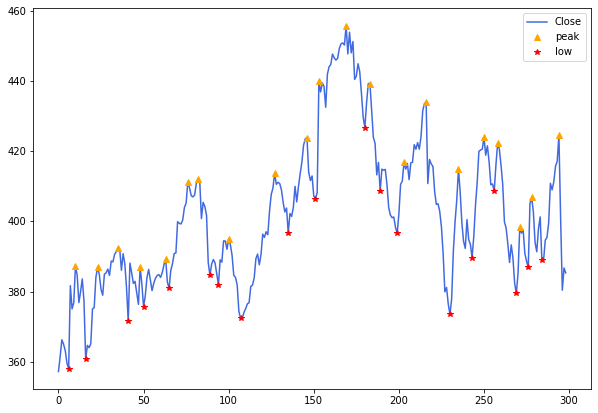

In [25]:
print("Размечаем таргет...")
mark_data_targets(stocks, window=10)

# отрисовываем график таргеты
stocks["Close"].plot(figsize=[10,7], color="royalblue")
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak", color="orange")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low", color="red")

_ = plt.legend()

In [26]:
stocks

,Date,Open,High,Low,Close,Volume,lows,peaks
0,2021-01-04,364.917345,366.946884,352.940047,357.179108,283100,0.0,0.0
1,2021-01-05,357.649040,363.567683,356.489299,361.388184,170400,0.0,0.0
2,2021-01-06,361.468119,367.306823,361.118223,366.227051,207900,0.0,0.0
3,2021-01-07,366.746944,371.205957,362.847833,364.977356,218100,0.0,0.0
4,2021-01-08,364.797386,369.126393,359.328624,363.147766,349400,0.0,0.0
...,...,...,...,...,...,...,...,...
294,2022-03-04,412.790009,430.670013,410.019989,424.540009,638200,0.0,1.0
295,2022-03-07,419.779999,420.440002,397.679993,401.209991,572800,0.0,0.0
296,2022-03-08,399.559998,401.410004,380.309998,380.390015,492600,0.0,0.0
297,2022-03-09,386.119995,389.369995,381.679993,386.730011,408500,0.0,0.0


# Уровни поддержики и сопротивления

In [89]:
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)

# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level, _ in levels])==0

# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))  
   
  candlestick_ohlc(ax, df.values, width=0.6, colorup='green', 
    colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)

  support_levels = [level for level in levels if level[2]=="s"]
  resistance_levels = [level for level in levels if level[2]=="r"]

  def plot_levels(lvls):
    for i in range(len(lvls)):
      level = lvls[i]
      x_min = df['Date'][level[0]]
      if i == len(lvls)-1:
        x_max = max(df['Date'])
      else:
        next_level = lvls[i+1]
        x_max = df['Date'][next_level[0]]
        #x_max = max(df['Date'][next_level[0]])

      if level[2]=="r":
        c = "green"
      elif level[2]=="s":
        c = "red"
      else:
        c="yellow"

      plt.hlines(level[1], xmin = x_min, xmax = x_max,
                colors=c, linestyle='--')
      
  plot_levels(support_levels)
  plot_levels(resistance_levels)
  
  fig.show()

In [90]:
df = stocks[["Date",	"Open", "Close",	"High",	"Low", "Volume"]].copy(deep=True)

df.Date = pd.to_datetime(df.Date)
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df["Date"] = df["Date"].apply(mpl_dates.date2num)


## method 1: fractal candlestick pattern

In [91]:
#method 1: fractal candlestick pattern
def detect_level_method_1(df):
  levels = []
  for i in range(2,df.shape[0]-2):
    if is_support(df,i):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l, "s"))
    elif is_resistance(df,i):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l, "r"))
  return levels

In [92]:
levels_1[2]

(23, 391.9018167587679, 'r')

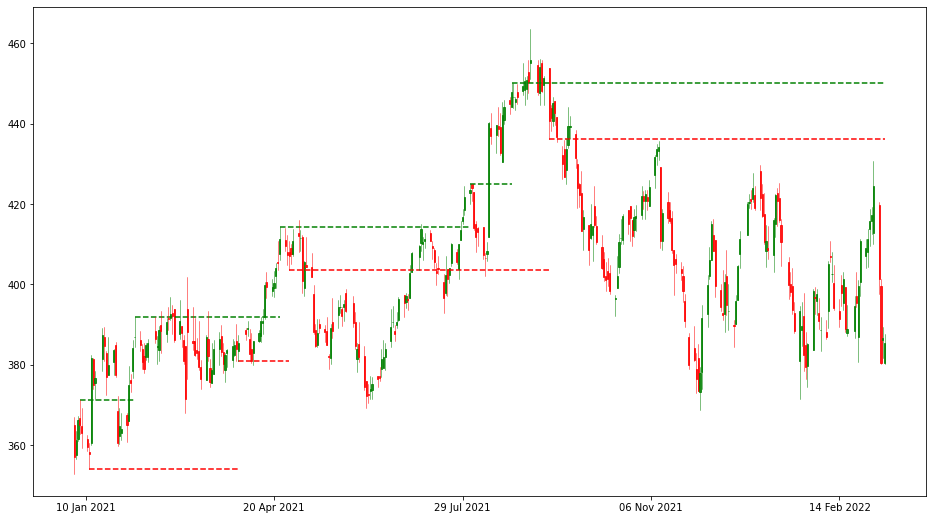

In [93]:
levels_1 = detect_level_method_1(df)
plot_all(levels_1, df)

#method 2: window shifting method

In [96]:
#method 2: window shifting method
def detect_level_method_2(df):
  levels = []
  max_list = []
  min_list = []
  for i in range(5, len(df)-5):
      high_range = df['High'][i-5:i+4]
      current_max = high_range.max()
      if current_max not in max_list:
          max_list = []
      max_list.append(current_max)
      if len(max_list) == 5 and is_far_from_level(current_max, levels, df):
          levels.append((high_range.idxmax(), current_max, "r"))
      
      low_range = df['Low'][i-5:i+5]
      current_min = low_range.min()
      if current_min not in min_list:
          min_list = []
      min_list.append(current_min)
      if len(min_list) == 5 and is_far_from_level(current_min, levels, df):
          levels.append((low_range.idxmin(), current_min, "s"))
  return levels

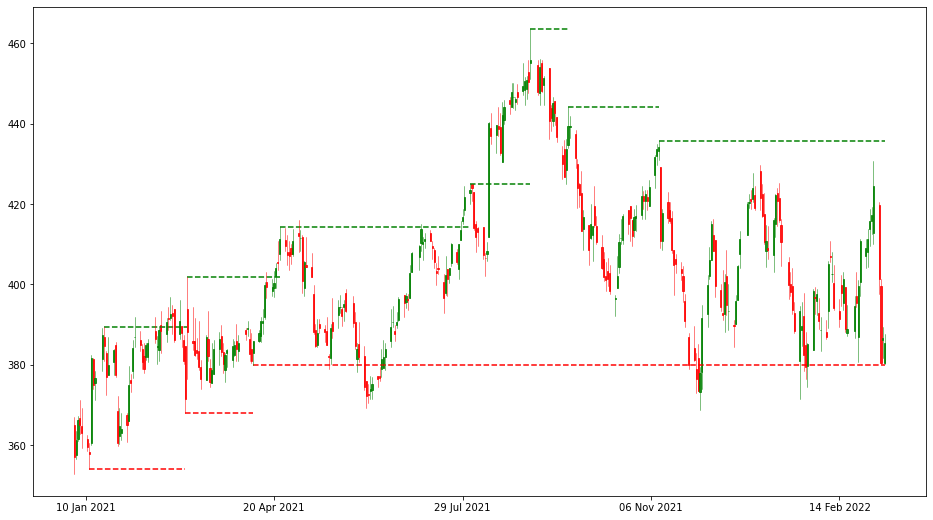

In [97]:
levels_2 = detect_level_method_2(df)
plot_all(levels_2, df)

# Поиск пробитий

In [99]:
# to detect breakout
def has_breakout(levels, previous, last):
  for _, level, t in levels:
    #тут надо написать адекватные критерии пробития саппорта и резиста
    cond1 = (previous['Open'] < level) 
    cond2 = (last['Open'] > level) and (last['Low'] > level)
  return (cond1 and cond2)

has_bo_1 = False
has_bo_2 = False

try:     
    # get levels using the first method
  levels_1 = detect_level_method_1(df)
  if (has_breakout(levels_1[-5:], df.iloc[-2], df.iloc[-1])):
    has_bo_1 = True

  # get levels using the second method
  levels_2 = detect_level_method_2(df)
  if (has_breakout(levels_2[-5:], df.iloc[-2], df.iloc[-1])):
    has_bo_2 = True

except Exception as e:
  print(e)

In [100]:
has_bo_1

False

In [101]:
has_bo_2

False

#Стратегия на основе пробитий

# Валидация стратегии

In [ ]:
money_hist_train, money_train, eq_train = validate(train_data, start_money = 10000, verbose=2)

In [ ]:
plt.plot(money_hist_train)

In [ ]:
money_hist_test, money_test, eq_test = validate(test_data, start_money = 10000, verbose=2)

In [ ]:
plt.plot(money_hist_test)